# Анализ данных: финальный проект
## Прогнозирование временных рядов на карте
### I. Знакомство с данными и агрегация
Обработка сырых данных по схеме:
    * Чистка данных от ошибок и аномалий.
    * Удаление минут и секунд во времени начала поездки.
    * Разбить прямоугольник Нью-Йорка на 2500 одинаковых прямоугольных областей. Нью-Йорк вписан в прямоугольник от -74.25559 до -73.70001 градусов долготы и от 40.49612 до 40.91553 широты.
    * Подсчет количества поездок за каждый час из каждой области. При этом, если в сырых данных для какой-то пары час-область нет ни одной записи, то в агрегированных данных для неё должен стоять 0.
    
Задание:
1. Загрузите данные за май 2016 года.
2. Проведите фильтрацию: удалите поездки с
    * нулевой длительностью
    * нулевым количеством пассажиров
    * нулевым расстоянием поездки по счётчику
    * координатами начала, не попадающими в прямоугольник Нью-Йорка
3. Агрегируйте данные за май 2016 года по часам и областям (можно использовать функцию stats.binned_statistic_2d, с которой вы сталкивались в заданиях четвёртого курса). Не забудьте проверить, что идентификаторы, которые вы присваиваете ячейкам, соответствуют приложенному выше файлу.
4. Выведите первые строки полученной таблицы.
5. Постройте график количества поездок жёлтого такси из ячейки, содержащей Empire State Building.
6. Посчитайте, сколько в мае 2016 было пар час-ячейка, для которых не было совершено ни одной поездки.

In [72]:
import numpy as np
import pandas as pd
from scipy.stats import binned_statistic_2d
import matplotlib.pyplot as plt

%matplotlib inline

## 1. Загрузка данных за май 2016 года.
Так как файл с данными большой (1,8 ГБ), желательно загружать его, указывая типы полей, так как иначе определение типа происходит позже, когда уже все данные в памяти.

In [2]:
%%time
df = pd.read_csv("yellow_tripdata_2016-05.csv", sep=',', dtype={"VendorID":np.int8,
                                                                            "passenger_count":np.int8,
                                                                            "trip_distance":float,
                                                                            "pickup_longitude":float,
                                                                            "pickup_latitude":float,
                                                                            "RatecodeID":np.int8,
                                                                            "store_and_fwd_flag":str,
                                                                            "dropoff_longitude":float,
                                                                            "dropoff_latitude":float,
                                                                            "payment_type":np.int8,
                                                                            "fare_amount":float,
                                                                            "extra":float,
                                                                            "mta_tax":float,
                                                                            "tip_amount":float,
                                                                            "tolls_amount":float,
                                                                            "improvement_surcharge":float,
                                                                            "total_amount":float})

Wall time: 36.1 s


In [3]:
df['store_and_fwd_flag'].replace(['N', 'Y'],[0, 1], inplace=True)
df['store_and_fwd_flag'] = df['store_and_fwd_flag'].astype(np.int8)

In [4]:
df["tpep_pickup_datetime"] = pd.to_datetime(df["tpep_pickup_datetime"],format="%Y-%m-%d %H:%M:%S")
df["tpep_dropoff_datetime"] = pd.to_datetime(df["tpep_dropoff_datetime"],format="%Y-%m-%d %H:%M:%S")
df['trip_duration'] = (df["tpep_dropoff_datetime"] - df["tpep_pickup_datetime"]).astype('timedelta64[s]')
del(df['tpep_dropoff_datetime'])

In [5]:
# Сократим формат даты и времени старта до даты и часов.
df.tpep_pickup_datetime =df.tpep_pickup_datetime.map(lambda t: t.strftime('%Y-%m-%d %H'))

# Вариант:
# df['tpep_pickup_datetime'] = df['tpep_pickup_datetime'].values.astype('<M8[h]')

In [6]:
df.head()

,VendorID,tpep_pickup_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RatecodeID,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,trip_duration
0,1,2016-05-01 00,1,3.60,-73.985901,40.768040,1,0,-73.983986,40.730099,1,15.0,0.5,0.5,1.50,0.0,0.3,17.80,1051.0
1,2,2016-05-01 00,1,1.68,-73.991577,40.744751,1,0,-73.975700,40.765469,1,7.5,0.5,0.5,0.88,0.0,0.3,9.68,451.0
2,2,2016-05-01 00,6,1.09,-73.993073,40.741573,1,0,-73.980995,40.744633,1,6.5,0.5,0.5,1.56,0.0,0.3,9.36,421.0
3,2,2016-05-01 00,1,4.21,-73.991943,40.684601,1,0,-74.002258,40.733002,1,17.0,0.5,0.5,3.66,0.0,0.3,21.96,1187.0
4,2,2016-05-01 00,1,0.56,-74.005280,40.740192,1,0,-73.997498,40.737564,1,6.0,0.5,0.5,1.46,0.0,0.3,8.76,399.0


In [7]:
df.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11836853 entries, 0 to 11836852
Data columns (total 19 columns):
VendorID                 11836853 non-null int8
tpep_pickup_datetime     11836853 non-null object
passenger_count          11836853 non-null int8
trip_distance            11836853 non-null float64
pickup_longitude         11836853 non-null float64
pickup_latitude          11836853 non-null float64
RatecodeID               11836853 non-null int8
store_and_fwd_flag       11836853 non-null int8
dropoff_longitude        11836853 non-null float64
dropoff_latitude         11836853 non-null float64
payment_type             11836853 non-null int8
fare_amount              11836853 non-null float64
extra                    11836853 non-null float64
mta_tax                  11836853 non-null float64
tip_amount               11836853 non-null float64
tolls_amount             11836853 non-null float64
improvement_surcharge    11836853 non-null float64
total_amount             11836853 

In [8]:
# make_structure_df - Функция создания пандас-таблицы, описывающей структуру данных 
# Параметры:
# make_col_df - создать таблицу (True) или просто вывести на печать краткую структуру данных (False)
# nan_count - показать количетсов пропущенных данных в столбце
# max_nuniques_for_print - максимальное количество уникальных значений для вывода в столбце "uniques"
# max_nuniques_as_categorial - максимальное количество уникальных значений в столбце, при котором тип столбца признаётся категориальным

def make_structure_df(data, make_col_df=True, nan_count=False, max_nuniques_for_print = 9, max_nuniques_as_categorial = 9):
    
    columns=['col_name', 'col_type', 'type', 'nunique', 'uniques',]
    
    if make_col_df == True:
        cols = []
    for col_name in data.columns:
        
        col_nunique = data[col_name].nunique()
        ctype = data[col_name].dtype.name
        
        if make_col_df == True:
            if (ctype == 'object') or (col_nunique <= max_nuniques_as_categorial):
                col_type = "categorial"
            elif ctype == 'datetime64[ns]':
                col_type = "datatime"
            else:
                col_type = "numeric"
            
            col_uniques = "..."
            if col_nunique <= max_nuniques_for_print:
                col_uniques = data[col_name].unique()
            cols.append([col_name, col_type, ctype, col_nunique, col_uniques])
    
    structure_df = pd.DataFrame(cols, columns=columns)
        
    if nan_count == True:
        structure_df['nan_count'] = data.isnull().sum(axis=0).tolist()
    
    return structure_df

In [9]:
df_structure = make_structure_df(df)
df_structure

,col_name,col_type,type,nunique,uniques
0,VendorID,categorial,int8,2,"[1, 2]"
1,tpep_pickup_datetime,categorial,object,744,...
2,passenger_count,numeric,int8,10,...
3,trip_distance,numeric,float64,4651,...
4,pickup_longitude,numeric,float64,35393,...
5,pickup_latitude,numeric,float64,62855,...
6,RatecodeID,categorial,int8,7,"[1, 2, 5, 4, 3, 99, 6]"
7,store_and_fwd_flag,categorial,int8,2,"[0, 1]"
8,dropoff_longitude,numeric,float64,55901,...
9,dropoff_latitude,numeric,float64,89505,...


In [10]:
df.describe()

,VendorID,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RatecodeID,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,trip_duration
count,1.183685e+07,1.183685e+07,1.183685e+07,1.183685e+07,1.183685e+07,1.183685e+07,1.183685e+07,1.183685e+07,1.183685e+07,1.183685e+07,1.183685e+07,1.183685e+07,1.183685e+07,1.183685e+07,1.183685e+07,1.183685e+07,1.183685e+07,1.183685e+07
mean,1.529075e+00,1.662265e+00,6.110069e+00,-7.304978e+01,4.024234e+01,1.045014e+00,5.381329e-03,-7.311869e+01,4.028127e+01,1.349840e+00,1.334066e+01,3.291893e-01,4.972577e-01,1.831982e+00,3.422044e-01,2.996838e-01,1.664095e+01,1.000449e+03
std,4.991539e-01,1.304418e+00,5.155162e+03,8.212003e+00,4.523904e+00,6.203209e-01,7.315990e-02,7.902544e+00,4.353644e+00,4.942504e-01,1.188799e+01,4.585669e-01,4.473578e-02,2.665043e+00,1.760303e+00,1.300760e-02,1.450379e+01,7.039696e+03
min,1.000000e+00,0.000000e+00,0.000000e+00,-1.650819e+02,-4.456935e+01,1.000000e+00,0.000000e+00,-1.295732e+02,0.000000e+00,1.000000e+00,-4.100000e+02,-3.900000e+01,-2.700000e+00,-8.000000e+01,-1.500000e+01,-3.000000e-01,-4.103000e+02,-8.188263e+06
25%,1.000000e+00,1.000000e+00,1.000000e+00,-7.399179e+01,4.073611e+01,1.000000e+00,0.000000e+00,-7.399116e+01,4.073457e+01,1.000000e+00,6.500000e+00,0.000000e+00,5.000000e-01,0.000000e+00,0.000000e+00,3.000000e-01,8.760000e+00,4.070000e+02
50%,2.000000e+00,1.000000e+00,1.720000e+00,-7.398136e+01,4.075375e+01,1.000000e+00,0.000000e+00,-7.397922e+01,4.075439e+01,1.000000e+00,9.500000e+00,0.000000e+00,5.000000e-01,1.260000e+00,0.000000e+00,3.000000e-01,1.230000e+01,6.880000e+02
75%,2.000000e+00,2.000000e+00,3.270000e+00,-7.396588e+01,4.076862e+01,1.000000e+00,0.000000e+00,-7.396164e+01,4.077012e+01,2.000000e+00,1.500000e+01,5.000000e-01,5.000000e-01,2.450000e+00,0.000000e+00,3.000000e-01,1.836000e+01,1.131000e+03
max,2.000000e+00,9.000000e+00,1.200000e+07,1.184089e+02,5.366724e+01,9.900000e+01,1.000000e+00,0.000000e+00,7.012994e+01,5.000000e+00,8.007000e+03,7.900000e+01,4.030000e+01,7.500000e+02,1.120680e+03,3.100000e+00,8.007800e+03,6.056060e+05


## Фильтрация данных

In [11]:
# Удаление поездок с нулевой и отрицательной длительностью
df = df[df.trip_duration > 0]

In [12]:
# Удаление поездок с нулевым количеством пассажиров
df = df[df.passenger_count != 0]

In [13]:
# Удаление поездок с нулевым расстоянием поездки по счётчику
df = df[df.trip_distance != 0]

Нью-Йорк вписан в прямоугольник от -74.25559 до -73.70001 градусов долготы и от 40.49612 до 40.91553 широты.
Отфильтруем значения не входящие в эти ограничения координат.

In [14]:
min_lat = 40.49612
max_lat = 40.91553
min_lon = -74.25559
max_lon = -73.70001
df = df[df.pickup_longitude >= min_lon]
df = df[df.pickup_longitude <= max_lon]
df = df[df.pickup_latitude >= min_lat]
df = df[df.pickup_latitude <= max_lat]

In [113]:
# Или можно было одной строкой:
# df = df[(df.trip_distance > 0) & (df.passenger_count > 0) & (df.fare_amount > 0) & (df.pickup_longitude >= -74.25559) & (df.pickup_longitude <= -73.70001) & (df.pickup_latitude >= 40.49612) & (df.pickup_latitude <= 40.91553)]

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11626521 entries, 0 to 11836841
Data columns (total 19 columns):
VendorID                 int8
tpep_pickup_datetime     object
passenger_count          int8
trip_distance            float64
pickup_longitude         float64
pickup_latitude          float64
RatecodeID               int8
store_and_fwd_flag       int8
dropoff_longitude        float64
dropoff_latitude         float64
payment_type             int8
fare_amount              float64
extra                    float64
mta_tax                  float64
tip_amount               float64
tolls_amount             float64
improvement_surcharge    float64
total_amount             float64
trip_duration            float64
dtypes: float64(13), int8(5), object(1)
memory usage: 1.4+ GB


In [16]:
df.describe()

,VendorID,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RatecodeID,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,trip_duration
count,1.162652e+07,1.162652e+07,1.162652e+07,1.162652e+07,1.162652e+07,1.162652e+07,1.162652e+07,1.162652e+07,1.162652e+07,1.162652e+07,1.162652e+07,1.162652e+07,1.162652e+07,1.162652e+07,1.162652e+07,1.162652e+07,1.162652e+07,1.162652e+07
mean,1.532216e+00,1.665547e+00,6.183120e+00,-7.397297e+01,4.075091e+01,1.035855e+00,5.189515e-03,-7.394901e+01,4.073869e+01,1.346877e+00,1.329009e+01,3.293084e-01,4.979773e-01,1.827028e+00,3.411761e-01,2.998080e-01,1.658536e+01,1.010139e+03
std,4.989611e-01,1.307689e+00,5.201581e+03,3.891102e-02,2.853368e-02,3.893456e-01,7.185112e-02,1.328789e+00,7.327153e-01,4.908161e-01,1.112288e+01,4.467856e-01,3.449482e-02,2.573152e+00,1.713772e+00,1.067103e-02,1.381537e+01,3.286354e+03
min,1.000000e+00,1.000000e+00,1.000000e-02,-7.425517e+01,4.051407e+01,1.000000e+00,0.000000e+00,-9.521244e+01,0.000000e+00,1.000000e+00,-2.750000e+02,-4.500000e+00,-5.000000e-01,-8.000000e+01,-1.500000e+01,-3.000000e-01,-2.753000e+02,1.000000e+00
25%,1.000000e+00,1.000000e+00,1.020000e+00,-7.399193e+01,4.073718e+01,1.000000e+00,0.000000e+00,-7.399126e+01,4.073568e+01,1.000000e+00,6.500000e+00,0.000000e+00,5.000000e-01,0.000000e+00,0.000000e+00,3.000000e-01,8.760000e+00,4.110000e+02
50%,2.000000e+00,1.000000e+00,1.750000e+00,-7.398161e+01,4.075435e+01,1.000000e+00,0.000000e+00,-7.397950e+01,4.075484e+01,1.000000e+00,9.500000e+00,0.000000e+00,5.000000e-01,1.320000e+00,0.000000e+00,3.000000e-01,1.230000e+01,6.910000e+02
75%,2.000000e+00,2.000000e+00,3.300000e+00,-7.396674e+01,4.076882e+01,1.000000e+00,0.000000e+00,-7.396247e+01,4.077037e+01,2.000000e+00,1.500000e+01,5.000000e-01,5.000000e-01,2.450000e+00,0.000000e+00,3.000000e-01,1.836000e+01,1.135000e+03
max,2.000000e+00,9.000000e+00,1.200000e+07,-7.370009e+01,4.091525e+01,9.900000e+01,1.000000e+00,0.000000e+00,7.012994e+01,5.000000e+00,9.520000e+02,7.900000e+01,1.635000e+01,6.500000e+02,1.120680e+03,3.000000e-01,1.173480e+03,6.056060e+05


In [17]:
df[df.fare_amount < 0].shape

(3637, 19)

Все указанные в задании варианты фильтрации данных осуществлены. Но остаются ещё вопросы. Например, поездки с отрицательной платой. 3637 поездки. Есть вопросы и по поездкам меньше полумили.

In [18]:
df[df.trip_distance > 1000].shape

(14, 19)

14 поездок длинной более 1000 миль, причём на цене это не сказывается. Тоже наверняка выбросы.

In [19]:
df[df.trip_duration > 24*60*60].shape

(4, 19)

4 поездки дольше 24 часов, 16963 - больше 12 часов.

In [2]:
df.to_pickle("df_task1.pkl")
#df = pd.read_pickle("df_task1.pkl")

## 3. Агрегирование данных
Агрегируйте данные за май 2016 года по часам и областям (можно использовать функцию stats.binned_statistic_2d, с которой вы сталкивались в заданиях четвёртого курса). Не забудьте проверить, что идентификаторы, которые вы присваиваете ячейкам, соответствуют приложенному выше файлу.


4. Выведите первые строки полученной таблицы.
5. Постройте график количества поездок жёлтого такси из ячейки, содержащей Empire State Building.
6. Посчитайте, сколько в мае 2016 было пар час-ячейка, для которых не было совершено ни одной поездки.

In [4]:
res = binned_statistic_2d(df['pickup_longitude'].values, df['pickup_latitude'].values, 
                                None, statistic='count', bins=[50, 50], range=[[min_lon, max_lon], [min_lat, max_lat]], 
                                expand_binnumbers = True)

In [5]:
districts = []
for i in range(len(res.binnumber[0])):
    districts.append((res.binnumber[0][i]-1)*50+res.binnumber[1][i])

In [6]:
df['pickup_district'] = districts
del(districts)

In [7]:
df = df.drop(['pickup_longitude', 'pickup_latitude', 'dropoff_longitude','dropoff_latitude'], axis=1)

In [8]:
df['ones'] = np.ones(df.shape[0])

In [14]:
df.head()

,VendorID,tpep_pickup_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,trip_duration,pickup_district,ones
0,1,2016-05-01 00,1,3.60,1,0,1,15.0,0.5,0.5,1.50,0.0,0.3,17.80,1051.0,1233,1.0
1,2,2016-05-01 00,1,1.68,1,0,1,7.5,0.5,0.5,0.88,0.0,0.3,9.68,451.0,1180,1.0
2,2,2016-05-01 00,6,1.09,1,0,1,6.5,0.5,0.5,1.56,0.0,0.3,9.36,421.0,1180,1.0
3,2,2016-05-01 00,1,4.21,1,0,1,17.0,0.5,0.5,3.66,0.0,0.3,21.96,1187.0,1173,1.0
4,2,2016-05-01 00,1,0.56,1,0,1,6.0,0.5,0.5,1.46,0.0,0.3,8.76,399.0,1130,1.0


In [9]:
df_time_dist = df.pivot_table(values='ones', index=['tpep_pickup_datetime', 'pickup_district'], aggfunc=sum, fill_value=0)

In [13]:
sum(df_time_dist.values)

11626521

In [15]:
df_time_dist

tpep_pickup_datetime  pickup_district
2016-05-01 00         1015                  1
                      1017                  1
                      1029                  3
                      1030                  1
                      1033                  4
                      1068                  1
                      1072                  4
                      1075                 71
                      1076                 64
                      1077                 52
                      1078                  2
                      1096                  2
                      1122                  9
                      1123                  6
                      1125                 81
                      1126                259
                      1127                535
                      1128                691
                      1129                994
                      1130               1100
                      1131                

Количество поездок совпадает, из этой таблиц можно достать нужные данные.

In [23]:
df_td = pd.DataFrame(df_time_dist.index.levels[0])

In [27]:
df_td = df_td.set_index('tpep_pickup_datetime')

In [45]:
%%time
for i in range(2500):
    x = []
    for j in df_time_dist.index.levels[0]:
        if i+1 in df_time_dist.ix[j].index.values:
            a = df_time_dist.ix[j][i+1]
        else:
            a = 0
        x.append(a)
    df_td[i+1]=x

Wall time: 8min 33s


In [61]:
df_td.sum().sum()

11626521L

## 4. Первые строки полученной таблицы.

In [64]:
df_td.head()

,1,2,3,4,5,6,7,8,9,10,...,2491,2492,2493,2494,2495,2496,2497,2498,2499,2500
tpep_pickup_datetime,,,,,,,,,,,,,,,,,,,,,
2016-05-01 00,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2016-05-01 01,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2016-05-01 02,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2016-05-01 03,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2016-05-01 04,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [65]:
df_td.to_pickle("df_td.pkl") #Сохраним итог для будущего использования. 14 МБ

## 5. График количества поездок жёлтого такси из ячейки, содержащей Empire State Building.
Из wikipedia берём координаты здания - 40.747778°, -73.985833°
Так как задача разовая, используем приложенную к задаче таблицу райнов и находим, что это район № 1231.

Можно было так:

```

regions = pandas.read_csv('regions.csv', sep=';')
empire_state_building = regions[(regions.west <= -73.985428) & (regions.east >= -73.985428) & (regions.south <= 40.748817) & (regions.north >= 40.748817)]
print region

```

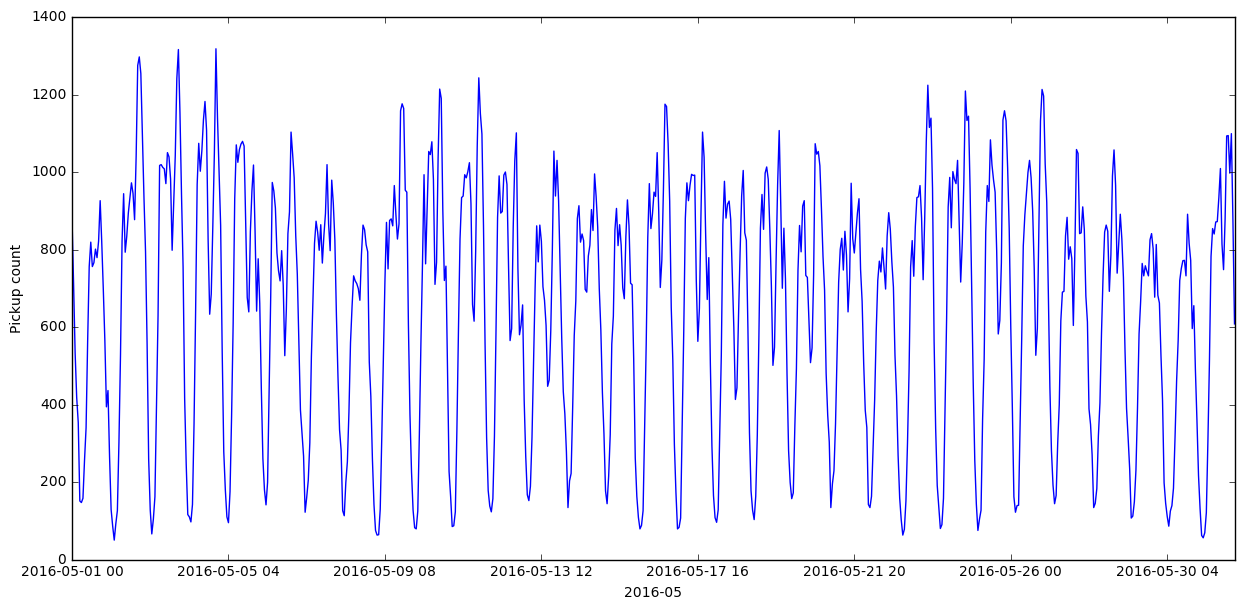

In [122]:
df_td[:][1231].plot(figsize=(15,7))
plt.ylabel('Pickup count')
plt.xlabel('2016-05')

## 6. Расчёт, количества пар час-ячейка, для которых в мае 2016 не было совершено ни одной поездки.

In [123]:
empty_td = (df_td[df_td.columns]==0).sum().sum()
empty_td

1718238L

Ни одной поедки не совершено в мае 2016 из 1 718 238 пары час-ячйка.

In [111]:
df_td.shape[0]*df_td.shape[1] - empty_td

141762L